In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading
import gc
import copy

sys.path.append("/end/home/rh2310/morpho_repo")
from turing.utils import *

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# Load data

In [2]:
layers = [3, 64, 64, 64, 64, 2]

data_path = os.path.abspath("turing_model_2.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t_model_2.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size

model_params = {'training_data_size': T*N,#T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

dataset = create_dataset(data, t_star, N, T, L, **model_params)
lb = dataset['lb']
ub = dataset['ub']
obs_X = dataset['obs_input']
obs_Y = dataset['obs_output']
pde_X = dataset['pde']


# NN Class

In [3]:
class NN(tf.Module):
    
    def __init__(self, layers, lb, ub, dtype=tf.float32, **kwargs):
        """A dense Neural Net that is specified by layers argument.
        
           layers: input, dense layers and outputs dimensions  
           lb    : An array of minimums of inputs (lower bounds)
           ub    : An array of maximums of inputs (upper bounds)
        """
        super().__init__(**kwargs)
        self.layers = layers
        self.num_layers = len(self.layers)        
        self.lb = lb
        self.ub = ub
        self.dtype = dtype
        self.build()
        
    def build(self):         
        """Create the state of the layers (weights)"""
        weights = []
        biases = []        
        for l in range(0,self.num_layers-1):
            W = self.xavier_init(size=[self.layers[l], self.layers[l+1]])
            b = tf.Variable(tf.zeros([1,self.layers[l+1]], dtype=self.dtype), dtype=self.dtype)
            weights.append(W)
            biases.append(b)
        
        self.Ws = weights
        self.bs = biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.compat.v1.truncated_normal([in_dim, out_dim], 
                                                         stddev=xavier_stddev, 
                                                         dtype=self.dtype), 
                           dtype=self.dtype)
    
        
    @tf.function
    def __net__(self, inputs):
        # Map the inputs to the range [-1, 1]
        H = 2.0*(inputs - self.lb)/(self.ub - self.lb) - 1.0
        for W, b in zip(self.Ws[:-1], self.bs[:-1]):
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            
        W = self.Ws[-1]
        b = self.bs[-1]
        outputs = tf.add(tf.matmul(H, W), b)
        return outputs
    
    def __call__(self, inputs):
        """Defines the computation from inputs to outputs
        
        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.           
                   
        Return:
                A tensor of the dense layer output that has a shape
                [None, Dn], where Dn is the dimensionality of the last
                layer, specificed by the last elements of the layer
                arguemnt.                                                
        """
        X = tf.cast(inputs, self.dtype)
        return self.__net__(X)
        
    def gradients(self, inputs, outputs):
        """finds the first and second order griadients of outputs at inputs
        
        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.
                   
        Return:   The returns 'partial_1' and 'partial_2' are the first and second 
                  order gradients, repsectivly. Each one is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, each list has Dn tensors as an elements. The dimensionality
                  of the tensors are the same as inputs: [None, D1]
        
        """
        partials_1 = [tf.gradients(outputs[:,i], inputs)[0] for i in range(outputs.shape[1])]
        partials_2 = [tf.gradients(partials_1[i], inputs)[0] for i in range(outputs.shape[1])]
        return partials_1, partials_2  
        
        
    def gradients_tape(self, inputs, outputs, tape):
        """finds the first and second order griadients of outputs at inputs
        
        Args:
           inputs: A tensor that has a shape [None, D1], where
                   D1 is the input dimensionality, specified in
                   the first element of layes.
           outputs:  A tensor that has a shape [None, Dn], where
                   Dn is the output dimensionality, specified in
                   the last element of layes.
           tape:   Gradient Tape object, for eager mode.
                   The outputs must be the list
                   of Tensors.
                   
        Return:   The returns 'partial' gradients. It is a list that its elements
                  corresponds to one of the NN's last layer output. e.g. if the last layer
                  has Dn outputs, the list has Dn tensors as an elements. The dimensionality
                  of the tensors is the same as inputs: [None, D1]
        
        """
        partials = [tape.gradient(outputs[i], inputs) for i in range(len(outputs))]
        #partials = tape.gradient([outputs[i] for i in range(len(outputs))], inputs) 
        return partials
        
    def copy(self):
        return copy.deepcopy(self)

In [15]:
def create_train(pinn, optimizer, train_acc_metric, epochs, print_interval = 1, train_params = True,
                 D_u = None, D_v = None, c_0 = None, c_1 = None, c_2 = None,
                 lambda_1 = 1.0, lambda_2 = 1.0, lambda_3 = 1.0, lambda_4 = 1.0):
    if D_u is None:
        D_u = tf.Variable(10.0,dtype=pinn.dtype, constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
    elif type(D_u) == float:
        D_u = tf.Variable(D_u,dtype=pinn.dtype, constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        
    if D_v is None:
        D_v = tf.Variable(10.0,dtype=pinn.dtype, constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
    elif type(D_v) == float:
        D_v = tf.Variable(D_v,dtype=pinn.dtype, constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        
    if c_0 is None:
        c_0 = tf.Variable(10.0,dtype=pinn.dtype, constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
    elif type(c_0) == float:
        c_0 = tf.Variable(c_0,dtype=pinn.dtype, constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        
    if c_1 is None:
        c_1 = tf.Variable(10.0,dtype=pinn.dtype, constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
    elif type(c_1) == float:
        c_1 = tf.Variable(c_1,dtype=pinn.dtype, constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        
    if c_2 is None:
        c_2 = tf.Variable(10.0,dtype=pinn.dtype, constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
    elif type(c_2) == float:
        c_2 = tf.Variable(c_2,dtype=pinn.dtype, constraint= lambda z: tf.clip_by_value(z, 0, 1e10))
        
    if train_params:
        trainable = (D_u, D_v, c_0, c_1, c_2)
    else:
        trainable = ()

    @tf.function
    def pde_test_var(inputs):  
        outputs = pinn(inputs)
        p1, p2 = pinn.gradients(inputs, outputs)
        u = outputs[:, 0]
        v = outputs[:, 1]

        u_x = tf.cast(p1[0][:, 0], pinn.dtype)
        u_y = tf.cast(p1[0][:, 1], pinn.dtype)
        u_t = tf.cast(p1[0][:, 2], pinn.dtype)

        u_xx = tf.cast(p2[0][:, 0], pinn.dtype)
        u_yy = tf.cast(p2[0][:, 1], pinn.dtype)


        v_x = tf.cast(p1[1][:, 0], pinn.dtype)
        v_y = tf.cast(p1[1][:, 1], pinn.dtype)
        v_t = tf.cast(p1[1][:, 2], pinn.dtype)

        v_xx = tf.cast(p2[1][:, 0], pinn.dtype)
        v_yy = tf.cast(p2[1][:, 1], pinn.dtype)


        u2v = u*u*v
        f_u = u_t - D_u*(u_xx + u_yy) - c_1 + c_0*u -  u2v
        f_v = v_t - D_v*(v_xx + v_yy) - c_2 + u2v
        return outputs, f_u, f_v


    @tf.function
    def train_step(x, y):
        with tf.GradientTape(persistent=True) as tape:
            outputs, f_u, f_v = pde_test_var(x)

            loss_obs_u = tf.reduce_mean(tf.square(y[:,0] - outputs[:,0]))
            loss_obs_v = tf.reduce_mean(tf.square(y[:,1] - outputs[:,1]))
            loss_pde_u = tf.reduce_mean(tf.square(f_u)) 
            loss_pde_v = tf.reduce_mean(tf.square(f_v))

            loss_value = lambda_1*loss_obs_u + lambda_2*loss_obs_v + \
                         lambda_3*loss_pde_u + lambda_4*loss_pde_v

        grads = tape.gradient(loss_value, pinn.trainable_variables + trainable)

        optimizer.apply_gradients(zip(grads, pinn.trainable_variables + trainable))
        train_acc_metric.update_state(y, outputs)
        return loss_value, loss_obs_u, loss_obs_v, loss_pde_u, loss_pde_v

    def find_grads():
        grad_norm_obs_u = tf.Variable(0., dtype=pinn.dtype, trainable=False)
        grad_norm_obs_v = tf.Variable(0., dtype=pinn.dtype, trainable=False)
        grad_norm_pde_u = tf.Variable(0., dtype=pinn.dtype, trainable=False)
        grad_norm_pde_v = tf.Variable(0., dtype=pinn.dtype, trainable=False)
        
        
        grad_norm_obs_u_lambda = tf.Variable(0., dtype=pinn.dtype, trainable=False)
        grad_norm_obs_v_lambda = tf.Variable(0., dtype=pinn.dtype, trainable=False)
        grad_norm_pde_u_lambda = tf.Variable(0., dtype=pinn.dtype, trainable=False)
        grad_norm_pde_v_lambda = tf.Variable(0., dtype=pinn.dtype, trainable=False)
        
        @tf.function
        def find_grads_step(x, y, first_step):
            with tf.GradientTape(persistent=True) as tape:
                #outputs = pinn(x)
                outputs, f_u, f_v = pde_test_var(x)        
                loss_obs_u = tf.reduce_mean(tf.square(y[:,0] - outputs[:,0]))
                loss_obs_v = tf.reduce_mean(tf.square(y[:,1] - outputs[:,1]))
                loss_pde_u = tf.reduce_mean(tf.square(f_u)) 
                loss_pde_v = tf.reduce_mean(tf.square(f_v))
                
                loss_obs_u_lambda = lambda_1*tf.reduce_mean(tf.square(y[:,0] - outputs[:,0]))
                loss_obs_v_lambda = lambda_2*tf.reduce_mean(tf.square(y[:,1] - outputs[:,1]))
                loss_pde_u_lambda = lambda_3*tf.reduce_mean(tf.square(f_u)) 
                loss_pde_v_lambda = lambda_4*tf.reduce_mean(tf.square(f_v))
        
            def get_grads_sum(loss):
                g = tape.gradient(loss, pinn.trainable_variables + trainable)
                return tf.reduce_sum([tf.reduce_sum(tf.square(item)) for item in g])
            
            grad_obs_u = get_grads_sum(loss_obs_u)
            grad_obs_v = get_grads_sum(loss_obs_v)
            grad_pde_u = get_grads_sum(loss_pde_u)
            grad_pde_v = get_grads_sum(loss_pde_v)
            
            grad_obs_u_lambda = get_grads_sum(loss_obs_u_lambda)
            grad_obs_v_lambda = get_grads_sum(loss_obs_v_lambda)
            grad_pde_u_lambda = get_grads_sum(loss_pde_u_lambda)
            grad_pde_v_lambda = get_grads_sum(loss_pde_v_lambda)


            if first_step:
                grad_norm_obs_u.assign(grad_obs_u)
                grad_norm_obs_v.assign(grad_obs_v)
                grad_norm_pde_u.assign(grad_pde_u)
                grad_norm_pde_v.assign(grad_pde_v)
                
                grad_norm_obs_u_lambda.assign(grad_obs_u_lambda)
                grad_norm_obs_v_lambda.assign(grad_obs_v_lambda)
                grad_norm_pde_u_lambda.assign(grad_pde_u_lambda)
                grad_norm_pde_v_lambda.assign(grad_pde_v_lambda)

            else:
                grad_norm_obs_u.assign(grad_norm_obs_u + grad_obs_u)
                grad_norm_obs_v.assign(grad_norm_obs_v + grad_obs_v)
                grad_norm_pde_u.assign(grad_norm_pde_u + grad_pde_u)
                grad_norm_pde_v.assign(grad_norm_pde_v + grad_pde_v)
                
                grad_norm_obs_u_lambda.assign(grad_norm_obs_u_lambda + grad_obs_u_lambda)
                grad_norm_obs_v_lambda.assign(grad_norm_obs_v_lambda + grad_obs_v_lambda)
                grad_norm_pde_u_lambda.assign(grad_norm_pde_u_lambda + grad_pde_u_lambda)
                grad_norm_pde_v_lambda.assign(grad_norm_pde_v_lambda + grad_pde_v_lambda)
                
        for step, o_batch_indices in enumerate(indice(batch_size, shuffle, obs_size)):
            x_batch_train, y_batch_train = obs_X[o_batch_indices], obs_Y[o_batch_indices]
            find_grads_step(x_batch_train, y_batch_train, step == 0)
            
        return (grad_norm_obs_u, grad_norm_obs_v, grad_norm_pde_u, grad_norm_pde_v, 
                grad_norm_obs_u_lambda, grad_norm_obs_v_lambda, grad_norm_pde_u_lambda, grad_norm_pde_v_lambda)


        



    arr_loss_obs_u = np.zeros(epochs)
    arr_loss_obs_v = np.zeros(epochs)
    arr_loss_pde_u = np.zeros(epochs)
    arr_loss_pde_v = np.zeros(epochs)

    arr_D_u = np.zeros(epochs)
    arr_D_v = np.zeros(epochs)
    arr_c_0 = np.zeros(epochs)
    arr_c_1 = np.zeros(epochs)
    arr_c_2 = np.zeros(epochs)

    start_time = time.time()

    for epoch in range(epochs):
        if epoch%print_interval == 0:
            print("\nStart of epoch %d" % (epoch,))


        loss_obs_u, loss_obs_v, loss_pde_u, loss_pde_v = 0, 0, 0, 0

        # Iterate over the batches of the dataset.
        for step, o_batch_indices in enumerate(indice(batch_size, shuffle, obs_size)):


            x_batch_train, y_batch_train = obs_X[o_batch_indices], obs_Y[o_batch_indices]

            loss_value, loss_obs_u_batch, loss_obs_v_batch, loss_pde_u_batch, loss_pde_v_batch = \
                           train_step(x_batch_train, y_batch_train)


            loss_obs_u += loss_obs_u_batch
            loss_obs_v += loss_obs_v_batch
            loss_pde_u += loss_pde_u_batch
            loss_pde_v += loss_pde_v_batch


        # Display metrics at the end of each epoch.
        if epoch%print_interval == 0:
            train_acc = train_acc_metric.result()    
            print("Training acc over epoch: %.4f" % (float(train_acc),))
            print(f"obs u: {loss_obs_u:.5f}, obs v: {loss_obs_v:.5f}, pde u:{loss_pde_u:.5f}, pde v:{loss_pde_v:.5f}")
            print(f"D_u: {D_u.numpy():.5f}, D_v: {D_v.numpy():.5f}, \n"
                  f"c_0: {c_0.numpy():.5f}, c_1: {c_1.numpy():.5f}, c_2: {c_2.numpy():.5f}")

        arr_loss_obs_u[epoch] = loss_obs_u
        arr_loss_obs_v[epoch] = loss_obs_v
        arr_loss_pde_u[epoch] = loss_pde_u
        arr_loss_pde_v[epoch] = loss_pde_v

        arr_D_u[epoch] = np.sqrt(D_u.numpy())
        arr_D_v[epoch] = np.sqrt(D_v.numpy())
        arr_c_0[epoch] = np.sqrt(c_0.numpy())
        arr_c_1[epoch] = np.sqrt(c_1.numpy())
        arr_c_2[epoch] = np.sqrt(c_2.numpy())


        # Reset training metrics at the end of each epoch
        train_acc_metric.reset_states()
        if epoch%print_interval == 0:
            print("Time taken: %.2fs" % (time.time() - start_time))
            start_time = time.time()
    return (arr_loss_obs_u, arr_loss_obs_v, arr_loss_pde_u, arr_loss_pde_v,
            arr_D_u, arr_D_v, arr_c_0, arr_c_1, arr_c_2, D_u, D_v, c_0, c_1, c_2, find_grads)


In [12]:
def plot_losses(arr_loss_obs_u, arr_loss_obs_v, arr_loss_pde_u, arr_loss_pde_v,                
                arr_D_u, arr_D_v, arr_c_0, arr_c_1, arr_c_2,
                lambda_1, lambda_2, lambda_3, lambda_4,
                start=0, end=-1):
    _ = plt.figure(figsize=(14,5))
    plt.title("Real losses")
    arr_loss_total = arr_loss_obs_u +arr_loss_obs_v + arr_loss_pde_u+ arr_loss_pde_v
    plt.plot(arr_loss_total[start:end], label = "Total")
    plt.plot(arr_loss_obs_u[start:end], label = "Obs u")
    plt.plot(arr_loss_obs_v[start:end], label = "Obs v")
    plt.plot(arr_loss_pde_u[start:end], label = "PDE u")
    plt.plot(arr_loss_pde_v[start:end], label = "PDE v")
    plt.legend()
    plt.grid()
    plt.yscale('log')
    #plt.ylim([0.1,1000])
    plt.show()

    _ = plt.figure(figsize=(14,5))
    plt.title("Penalised losses")
    arr_loss_total = lambda_1*arr_loss_obs_u + lambda_2*arr_loss_obs_v + lambda_3*arr_loss_pde_u+ lambda_4*arr_loss_pde_v
    plt.plot(arr_loss_total[start:end], label = "Total")
    plt.plot(lambda_1*arr_loss_obs_u[start:end], label = "Obs u")
    plt.plot(lambda_2*arr_loss_obs_v[start:end], label = "Obs v")
    plt.plot(lambda_3*arr_loss_pde_u[start:end], label = "PDE u")
    plt.plot(lambda_4*arr_loss_pde_v[start:end], label = "PDE v")
    plt.legend()
    plt.grid()
    plt.yscale('log')
    #plt.ylim([0.1,1000])
    plt.show()

    
    _ = plt.figure(figsize=(14,5))
    plt.plot(arr_D_u[start:end], label = "D_u")
    plt.plot(arr_D_v[start:end], label = "D_v")
    plt.plot(arr_c_0[start:end], label = "c_0")
    plt.plot(arr_c_1[start:end], label = "c_1")
    plt.plot(arr_c_2[start:end], label = "c_2")

    plt.legend()
    plt.grid()
    plt.yscale('log')
    #plt.ylim([0.1,1000])
    plt.show()


In [35]:
np.random.seed(42)
tf.random.set_seed(42)
tf.compat.v1.set_random_seed(42)

pinn = NN(layers, lb, ub, dtype=tf.float64)
optimizer = keras.optimizers.Adam()

train_acc_metric = keras.metrics.MeanSquaredError()

shuffle=True
batch_size = 512
epochs = 400
obs_size = obs_X.shape[0]
pde_size = pde_X.shape[0]

In [36]:
(arr_loss_obs_u, arr_loss_obs_v, arr_loss_pde_u, arr_loss_pde_v,
            arr_D_u, arr_D_v, arr_c_0, 
 arr_c_1, arr_c_2,
D_u, D_v, c_0, c_1, c_2, 
 find_grads) = create_train(pinn, optimizer, train_acc_metric, epochs=200, train_params = False,
                           lambda_1 = 40.0, lambda_2 = 1.0, lambda_3 = 0.1, lambda_4 = 0.005,
                           )


Start of epoch 0
Training acc over epoch: 0.6207
obs u: 1239.84500, obs v: 31.32696, pde u:1517.76103, pde v:89738.16816
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 20.72s

Start of epoch 1
Training acc over epoch: 0.6097
obs u: 1228.25876, obs v: 20.48276, pde u:474.96350, pde v:89296.60784
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.51s

Start of epoch 2
Training acc over epoch: 0.6094
obs u: 1227.50108, obs v: 20.47536, pde u:434.46114, pde v:89300.22872
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.52s

Start of epoch 3
Training acc over epoch: 0.6093
obs u: 1227.17384, obs v: 20.65609, pde u:434.98495, pde v:89290.04603
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.41s

Start of epoch 4
Training acc over epoch: 0.6093
obs u: 1226.97999, obs v: 20.87215, pde u:443.43726, pde v:89272.30689
D_u: 10.00000, D_v

Training acc over epoch: 0.1604
obs u: 24.43648, obs v: 304.04886, pde u:11550.12881, pde v:72007.78759
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.43s

Start of epoch 39
Training acc over epoch: 0.1540
obs u: 23.79739, obs v: 291.58011, pde u:10797.01783, pde v:69044.98810
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.63s

Start of epoch 40
Training acc over epoch: 0.1496
obs u: 23.45410, obs v: 282.89777, pde u:10508.21053, pde v:67093.96870
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.55s

Start of epoch 41
Training acc over epoch: 0.1426
obs u: 22.78610, obs v: 269.25162, pde u:9832.10756, pde v:64834.42632
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.60s

Start of epoch 42
Training acc over epoch: 0.1375
obs u: 22.40338, obs v: 259.25834, pde u:9467.39495, pde v:63159.25749
D_u: 10.00000, D_v: 10.00000, 

Training acc over epoch: 0.0557
obs u: 14.93104, obs v: 99.04562, pde u:3734.14879, pde v:37162.54249
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.51s

Start of epoch 77
Training acc over epoch: 0.0543
obs u: 14.83461, obs v: 96.35686, pde u:3602.67970, pde v:36722.84082
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.46s

Start of epoch 78
Training acc over epoch: 0.0529
obs u: 14.75710, obs v: 93.61205, pde u:3517.33986, pde v:36219.62726
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.46s

Start of epoch 79
Training acc over epoch: 0.0517
obs u: 14.66017, obs v: 91.14910, pde u:3411.20270, pde v:35763.35330
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.49s

Start of epoch 80
Training acc over epoch: 0.0504
obs u: 14.48196, obs v: 88.68311, pde u:3291.05545, pde v:35318.61337
D_u: 10.00000, D_v: 10.00000, 
c_0: 10

Training acc over epoch: 0.0334
obs u: 11.84217, obs v: 56.64929, pde u:1689.58178, pde v:21709.44510
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.61s

Start of epoch 116
Training acc over epoch: 0.0332
obs u: 11.83599, obs v: 56.15887, pde u:1691.82879, pde v:21316.43116
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.46s

Start of epoch 117
Training acc over epoch: 0.0340
obs u: 11.99087, obs v: 57.57494, pde u:1894.27639, pde v:21154.53375
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.46s

Start of epoch 118
Training acc over epoch: 0.0324
obs u: 11.64325, obs v: 54.81322, pde u:1563.45251, pde v:20514.85446
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.53s

Start of epoch 119
Training acc over epoch: 0.0322
obs u: 11.66328, obs v: 54.24455, pde u:1610.26954, pde v:20226.34507
D_u: 10.00000, D_v: 10.00000, 
c_0

Training acc over epoch: 0.0260
obs u: 10.92042, obs v: 42.34036, pde u:1363.29000, pde v:14216.31991
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.71s

Start of epoch 154
Training acc over epoch: 0.0259
obs u: 11.02896, obs v: 42.06826, pde u:1471.73135, pde v:14228.29921
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.66s

Start of epoch 155
Training acc over epoch: 0.0252
obs u: 10.80265, obs v: 40.71221, pde u:1274.04042, pde v:13824.84700
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.46s

Start of epoch 156
Training acc over epoch: 0.0247
obs u: 10.77848, obs v: 39.77272, pde u:1274.45944, pde v:13685.86815
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.47s

Start of epoch 157
Training acc over epoch: 0.0244
obs u: 10.81261, obs v: 39.19300, pde u:1296.36421, pde v:13587.90159
D_u: 10.00000, D_v: 10.00000, 
c_0

Training acc over epoch: 0.0225
obs u: 10.30732, obs v: 35.71454, pde u:926.50171, pde v:10694.56495
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.59s

Start of epoch 192
Training acc over epoch: 0.0219
obs u: 10.23570, obs v: 34.55858, pde u:858.89812, pde v:10445.23019
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.61s

Start of epoch 193
Training acc over epoch: 0.0216
obs u: 10.24382, obs v: 34.04105, pde u:868.53730, pde v:10348.93207
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.65s

Start of epoch 194
Training acc over epoch: 0.0215
obs u: 10.26713, obs v: 33.73756, pde u:888.86490, pde v:10273.67705
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.00000, c_1: 10.00000, c_2: 10.00000
Time taken: 11.42s

Start of epoch 195
Training acc over epoch: 0.0211
obs u: 10.15614, obs v: 33.02503, pde u:904.69704, pde v:10120.82950
D_u: 10.00000, D_v: 10.00000, 
c_0: 10.

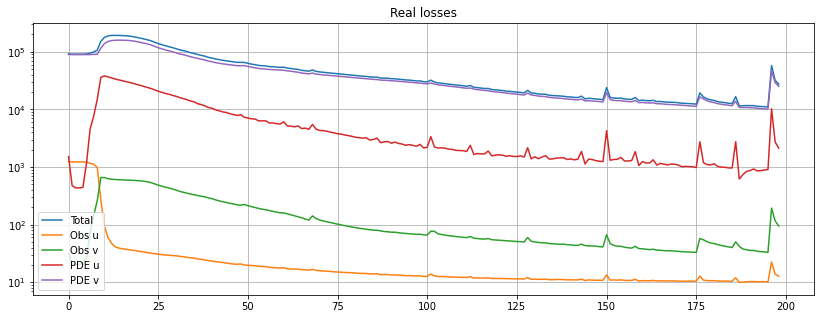

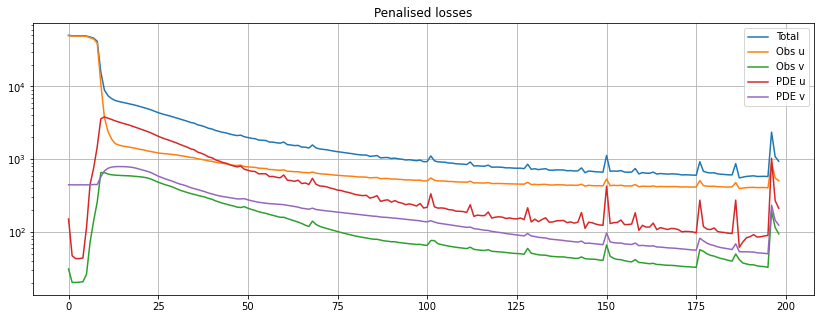

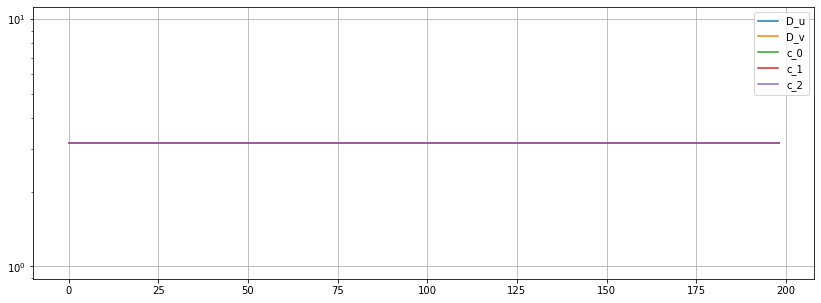

In [37]:
plot_losses(arr_loss_obs_u, arr_loss_obs_v, arr_loss_pde_u, arr_loss_pde_v,                
                arr_D_u, arr_D_v, arr_c_0, arr_c_1, arr_c_2,
                lambda_1 = 40.0, lambda_2 = 1.0, lambda_3 = 0.1, lambda_4 = 0.005,
                start=0, end=-1)

In [38]:
find_grads()

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=56.85330207367187>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=993.8849181998788>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=19748880.614326086>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=48280647.72982156>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=90965.2833178749>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=993.8849181998788>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=197488.80614326135>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1207.0161932455399>)

In [39]:
(arr_loss_obs_u_2, arr_loss_obs_v_2, arr_loss_pde_u_2, arr_loss_pde_v_2,
 arr_D_u_2, arr_D_v_2, arr_c_0_2, arr_c_1_2, arr_c_2_2,
 D_u, D_v, c_0, c_1, c_2, 
 find_grads_2) = create_train(pinn, optimizer, train_acc_metric, epochs=500, train_params = True,
                              lambda_1 = 40.0, lambda_2 = 1.0, lambda_3 = 0.1, lambda_4 = 0.005,
                              D_u=D_u, D_v=D_v, c_0=c_0, c_1=c_1, c_2=c_2)


Start of epoch 0
Training acc over epoch: 0.0358
obs u: 11.59950, obs v: 61.71492, pde u:1394.47087, pde v:16384.75472
D_u: 9.00634, D_v: 9.90468, 
c_0: 8.90850, c_1: 8.68171, c_2: 8.14666
Time taken: 15.99s

Start of epoch 1
Training acc over epoch: 0.0291
obs u: 11.34583, obs v: 48.32606, pde u:1311.32150, pde v:11891.41723
D_u: 8.50433, D_v: 9.42632, 
c_0: 8.32901, c_1: 7.97893, c_2: 7.12348
Time taken: 11.72s

Start of epoch 2
Training acc over epoch: 0.0237
obs u: 11.01657, obs v: 37.45475, pde u:1058.58403, pde v:9006.38781
D_u: 7.97283, D_v: 8.87365, 
c_0: 7.81650, c_1: 7.37595, c_2: 6.21762
Time taken: 11.62s

Start of epoch 3
Training acc over epoch: 0.0200
obs u: 10.66323, obs v: 30.27902, pde u:916.88245, pde v:6922.07094
D_u: 7.44190, D_v: 8.26589, 
c_0: 7.32251, c_1: 6.78593, c_2: 5.36899
Time taken: 11.55s

Start of epoch 4
Training acc over epoch: 0.0183
obs u: 10.81116, obs v: 26.57281, pde u:988.81131, pde v:5480.31628
D_u: 6.93762, D_v: 7.61494, 
c_0: 6.80869, c_1: 6

Training acc over epoch: 0.0057
obs u: 9.37131, obs v: 2.31863, pde u:15.38435, pde v:1025.10833
D_u: 0.02451, D_v: 4.74746, 
c_0: 1.01064, c_1: 0.24755, c_2: 0.75769
Time taken: 11.72s

Start of epoch 41
Training acc over epoch: 0.0057
obs u: 9.39529, obs v: 2.30594, pde u:15.35418, pde v:1015.13407
D_u: 0.03019, D_v: 4.89292, 
c_0: 1.01223, c_1: 0.25033, c_2: 0.77053
Time taken: 11.72s

Start of epoch 42
Training acc over epoch: 0.0057
obs u: 9.35273, obs v: 2.28686, pde u:15.18507, pde v:1004.63398
D_u: 0.02892, D_v: 4.98569, 
c_0: 1.01319, c_1: 0.25071, c_2: 0.75582
Time taken: 11.62s

Start of epoch 43
Training acc over epoch: 0.0057
obs u: 9.36970, obs v: 2.27509, pde u:15.29110, pde v:996.73293
D_u: 0.02412, D_v: 5.08502, 
c_0: 1.01422, c_1: 0.25124, c_2: 0.75768
Time taken: 11.59s

Start of epoch 44
Training acc over epoch: 0.0057
obs u: 9.32691, obs v: 2.26196, pde u:15.19019, pde v:988.30295
D_u: 0.03099, D_v: 5.19601, 
c_0: 1.01705, c_1: 0.25114, c_2: 0.75395
Time taken: 11.

Training acc over epoch: 0.0053
obs u: 8.87443, obs v: 2.06966, pde u:14.17459, pde v:813.95372
D_u: 0.03564, D_v: 6.28813, 
c_0: 1.02799, c_1: 0.25061, c_2: 0.74165
Time taken: 11.69s

Start of epoch 82
Training acc over epoch: 0.0053
obs u: 8.83931, obs v: 2.07593, pde u:14.10273, pde v:814.48328
D_u: 0.03223, D_v: 6.26909, 
c_0: 1.02742, c_1: 0.25327, c_2: 0.75494
Time taken: 11.62s

Start of epoch 83
Training acc over epoch: 0.0053
obs u: 8.81098, obs v: 2.07851, pde u:14.04192, pde v:817.52890
D_u: 0.03591, D_v: 6.22653, 
c_0: 1.02986, c_1: 0.25209, c_2: 0.74584
Time taken: 11.55s

Start of epoch 84
Training acc over epoch: 0.0053
obs u: 8.80691, obs v: 2.08233, pde u:14.20700, pde v:814.69093
D_u: 0.03609, D_v: 6.23715, 
c_0: 1.02795, c_1: 0.25401, c_2: 0.74655
Time taken: 11.56s

Start of epoch 85
Training acc over epoch: 0.0053
obs u: 8.83766, obs v: 2.07901, pde u:14.06189, pde v:811.44157
D_u: 0.03368, D_v: 6.23459, 
c_0: 1.02745, c_1: 0.25209, c_2: 0.74208
Time taken: 11.46s

Training acc over epoch: 0.0051
obs u: 8.24417, obs v: 2.10214, pde u:13.88530, pde v:796.59083
D_u: 0.02759, D_v: 5.46852, 
c_0: 1.02559, c_1: 0.25139, c_2: 0.75447
Time taken: 11.60s

Start of epoch 123
Training acc over epoch: 0.0050
obs u: 8.22766, obs v: 2.10462, pde u:13.84889, pde v:797.84920
D_u: 0.03219, D_v: 5.43195, 
c_0: 1.02689, c_1: 0.25058, c_2: 0.75545
Time taken: 11.56s

Start of epoch 124
Training acc over epoch: 0.0050
obs u: 8.13976, obs v: 2.10040, pde u:13.87122, pde v:799.44155
D_u: 0.03155, D_v: 5.44346, 
c_0: 1.02489, c_1: 0.24894, c_2: 0.74857
Time taken: 11.59s

Start of epoch 125
Training acc over epoch: 0.0050
obs u: 8.19534, obs v: 2.10241, pde u:13.72093, pde v:800.45485
D_u: 0.03329, D_v: 5.38848, 
c_0: 1.02534, c_1: 0.24838, c_2: 0.75237
Time taken: 11.65s

Start of epoch 126
Training acc over epoch: 0.0050
obs u: 8.14402, obs v: 2.11333, pde u:13.85770, pde v:800.88247
D_u: 0.02810, D_v: 5.36761, 
c_0: 1.02278, c_1: 0.24758, c_2: 0.76010
Time taken: 11

Training acc over epoch: 0.0044
obs u: 6.85356, obs v: 2.12918, pde u:14.40197, pde v:839.76972
D_u: 0.02130, D_v: 4.58460, 
c_0: 1.01949, c_1: 0.24851, c_2: 0.74018
Time taken: 11.57s

Start of epoch 163
Training acc over epoch: 0.0044
obs u: 6.83912, obs v: 2.12434, pde u:14.48020, pde v:839.27965
D_u: 0.02289, D_v: 4.55551, 
c_0: 1.02188, c_1: 0.24806, c_2: 0.75051
Time taken: 11.62s

Start of epoch 164
Training acc over epoch: 0.0044
obs u: 6.80915, obs v: 2.13166, pde u:14.51561, pde v:848.69805
D_u: 0.02359, D_v: 4.49268, 
c_0: 1.01841, c_1: 0.24690, c_2: 0.75134
Time taken: 11.71s

Start of epoch 165
Training acc over epoch: 0.0043
obs u: 6.73004, obs v: 2.12262, pde u:14.62723, pde v:847.46488
D_u: 0.02077, D_v: 4.48264, 
c_0: 1.02004, c_1: 0.24912, c_2: 0.75677
Time taken: 11.66s

Start of epoch 166
Training acc over epoch: 0.0043
obs u: 6.68503, obs v: 2.13393, pde u:14.80981, pde v:857.18393
D_u: 0.02060, D_v: 4.40038, 
c_0: 1.02065, c_1: 0.24750, c_2: 0.75621
Time taken: 11

Training acc over epoch: 0.0033
obs u: 4.65543, obs v: 2.11589, pde u:15.58676, pde v:887.94743
D_u: 0.01370, D_v: 3.93378, 
c_0: 1.02161, c_1: 0.24845, c_2: 0.75047
Time taken: 11.65s

Start of epoch 203
Training acc over epoch: 0.0033
obs u: 4.62684, obs v: 2.11268, pde u:15.38383, pde v:888.22127
D_u: 0.01110, D_v: 3.87128, 
c_0: 1.02158, c_1: 0.24855, c_2: 0.73864
Time taken: 11.62s

Start of epoch 204
Training acc over epoch: 0.0033
obs u: 4.55322, obs v: 2.12024, pde u:15.76509, pde v:890.72453
D_u: 0.01300, D_v: 3.87583, 
c_0: 1.02240, c_1: 0.25020, c_2: 0.75351
Time taken: 11.77s

Start of epoch 205
Training acc over epoch: 0.0032
obs u: 4.51610, obs v: 2.12356, pde u:15.58103, pde v:892.97421
D_u: 0.01661, D_v: 3.86678, 
c_0: 1.02042, c_1: 0.24770, c_2: 0.74817
Time taken: 11.59s

Start of epoch 206
Training acc over epoch: 0.0032
obs u: 4.43006, obs v: 2.12093, pde u:15.60564, pde v:888.64837
D_u: 0.01303, D_v: 3.89787, 
c_0: 1.02083, c_1: 0.24945, c_2: 0.74735
Time taken: 11

Training acc over epoch: 0.0027
obs u: 3.46582, obs v: 2.07531, pde u:15.51947, pde v:861.48165
D_u: 0.01651, D_v: 4.09926, 
c_0: 1.02408, c_1: 0.24863, c_2: 0.72942
Time taken: 11.69s

Start of epoch 243
Training acc over epoch: 0.0027
obs u: 3.47823, obs v: 2.07828, pde u:15.59853, pde v:875.59891
D_u: 0.01684, D_v: 4.05567, 
c_0: 1.02098, c_1: 0.25163, c_2: 0.72937
Time taken: 11.67s

Start of epoch 244
Training acc over epoch: 0.0027
obs u: 3.53836, obs v: 2.08725, pde u:15.35631, pde v:872.98932
D_u: 0.01390, D_v: 4.04299, 
c_0: 1.02254, c_1: 0.25042, c_2: 0.72372
Time taken: 11.72s

Start of epoch 245
Training acc over epoch: 0.0027
obs u: 3.48777, obs v: 2.08138, pde u:15.49166, pde v:862.81624
D_u: 0.01683, D_v: 4.09187, 
c_0: 1.02411, c_1: 0.25114, c_2: 0.71790
Time taken: 11.72s

Start of epoch 246
Training acc over epoch: 0.0027
obs u: 3.35578, obs v: 2.07468, pde u:15.42915, pde v:859.85881
D_u: 0.01676, D_v: 4.14673, 
c_0: 1.02332, c_1: 0.24788, c_2: 0.73059
Time taken: 11

Training acc over epoch: 0.0024
obs u: 2.92933, obs v: 2.08768, pde u:14.75539, pde v:823.10704
D_u: 0.01099, D_v: 4.17798, 
c_0: 1.02709, c_1: 0.25083, c_2: 0.70128
Time taken: 11.55s

Start of epoch 283
Training acc over epoch: 0.0025
obs u: 2.94837, obs v: 2.08470, pde u:14.69222, pde v:824.94921
D_u: 0.01675, D_v: 4.15379, 
c_0: 1.02541, c_1: 0.25092, c_2: 0.70731
Time taken: 11.57s

Start of epoch 284
Training acc over epoch: 0.0025
obs u: 3.02054, obs v: 2.07188, pde u:14.75342, pde v:821.44141
D_u: 0.01485, D_v: 4.21281, 
c_0: 1.02618, c_1: 0.25242, c_2: 0.71000
Time taken: 11.63s

Start of epoch 285
Training acc over epoch: 0.0025
obs u: 2.97130, obs v: 2.06787, pde u:14.61613, pde v:814.92769
D_u: 0.01762, D_v: 4.21369, 
c_0: 1.02618, c_1: 0.25120, c_2: 0.69841
Time taken: 11.68s

Start of epoch 286
Training acc over epoch: 0.0025
obs u: 3.06375, obs v: 2.06908, pde u:14.69764, pde v:812.89647
D_u: 0.01486, D_v: 4.20141, 
c_0: 1.02763, c_1: 0.25389, c_2: 0.69064
Time taken: 11

Training acc over epoch: 0.0023
obs u: 2.65348, obs v: 2.07468, pde u:14.27862, pde v:783.04664
D_u: 0.01735, D_v: 4.18755, 
c_0: 1.02701, c_1: 0.25238, c_2: 0.68085
Time taken: 11.60s

Start of epoch 323
Training acc over epoch: 0.0023
obs u: 2.67584, obs v: 2.05999, pde u:14.25613, pde v:783.66141
D_u: 0.01202, D_v: 4.19609, 
c_0: 1.02641, c_1: 0.25134, c_2: 0.69264
Time taken: 11.54s

Start of epoch 324
Training acc over epoch: 0.0023
obs u: 2.73290, obs v: 2.05860, pde u:14.26795, pde v:782.55076
D_u: 0.01340, D_v: 4.20170, 
c_0: 1.02910, c_1: 0.25584, c_2: 0.67729
Time taken: 11.57s

Start of epoch 325
Training acc over epoch: 0.0023
obs u: 2.69196, obs v: 2.06152, pde u:14.28840, pde v:773.15749
D_u: 0.01469, D_v: 4.22121, 
c_0: 1.03079, c_1: 0.25269, c_2: 0.67632
Time taken: 11.59s

Start of epoch 326
Training acc over epoch: 0.0023
obs u: 2.64314, obs v: 2.05251, pde u:14.20916, pde v:775.98985
D_u: 0.01515, D_v: 4.22895, 
c_0: 1.02950, c_1: 0.25298, c_2: 0.68049
Time taken: 11

Training acc over epoch: 0.0022
obs u: 2.53571, obs v: 2.06677, pde u:14.06552, pde v:767.94816
D_u: 0.01876, D_v: 4.21934, 
c_0: 1.02625, c_1: 0.24940, c_2: 0.67729
Time taken: 11.58s

Start of epoch 363
Training acc over epoch: 0.0022
obs u: 2.48128, obs v: 2.06610, pde u:14.13081, pde v:766.56761
D_u: 0.01514, D_v: 4.17458, 
c_0: 1.02829, c_1: 0.25341, c_2: 0.69552
Time taken: 11.55s

Start of epoch 364
Training acc over epoch: 0.0022
obs u: 2.52410, obs v: 2.07093, pde u:14.11002, pde v:769.87914
D_u: 0.01579, D_v: 4.17121, 
c_0: 1.02828, c_1: 0.25469, c_2: 0.68008
Time taken: 11.66s

Start of epoch 365
Training acc over epoch: 0.0022
obs u: 2.36497, obs v: 2.05327, pde u:14.14577, pde v:758.49887
D_u: 0.01404, D_v: 4.24642, 
c_0: 1.02686, c_1: 0.25071, c_2: 0.68809
Time taken: 11.69s

Start of epoch 366
Training acc over epoch: 0.0022
obs u: 2.52666, obs v: 2.05963, pde u:14.14776, pde v:768.45151
D_u: 0.01589, D_v: 4.17552, 
c_0: 1.02732, c_1: 0.25301, c_2: 0.67925
Time taken: 11

Training acc over epoch: 0.0021
obs u: 2.25420, obs v: 2.04179, pde u:14.04593, pde v:740.36630
D_u: 0.01954, D_v: 4.30068, 
c_0: 1.02866, c_1: 0.25212, c_2: 0.65145
Time taken: 11.61s

Start of epoch 403
Training acc over epoch: 0.0021
obs u: 2.26479, obs v: 2.04256, pde u:13.96895, pde v:740.45820
D_u: 0.02168, D_v: 4.29492, 
c_0: 1.02712, c_1: 0.25040, c_2: 0.66087
Time taken: 11.83s

Start of epoch 404
Training acc over epoch: 0.0021
obs u: 2.31187, obs v: 2.04722, pde u:13.87144, pde v:740.66706
D_u: 0.02380, D_v: 4.29160, 
c_0: 1.02868, c_1: 0.25332, c_2: 0.64893
Time taken: 11.68s

Start of epoch 405
Training acc over epoch: 0.0021
obs u: 2.30543, obs v: 2.03104, pde u:14.03046, pde v:741.47641
D_u: 0.01879, D_v: 4.21396, 
c_0: 1.02568, c_1: 0.25258, c_2: 0.66185
Time taken: 11.64s

Start of epoch 406
Training acc over epoch: 0.0021
obs u: 2.33036, obs v: 2.04346, pde u:13.94720, pde v:731.89810
D_u: 0.02037, D_v: 4.29321, 
c_0: 1.02925, c_1: 0.25403, c_2: 0.67535
Time taken: 11

Training acc over epoch: 0.0022
obs u: 2.41990, obs v: 2.04364, pde u:13.93275, pde v:738.38147
D_u: 0.01533, D_v: 4.20305, 
c_0: 1.02988, c_1: 0.25365, c_2: 0.66056
Time taken: 11.56s

Start of epoch 443
Training acc over epoch: 0.0020
obs u: 2.15007, obs v: 2.02754, pde u:13.92683, pde v:712.92637
D_u: 0.02209, D_v: 4.33253, 
c_0: 1.02679, c_1: 0.25208, c_2: 0.66949
Time taken: 11.57s

Start of epoch 444
Training acc over epoch: 0.0020
obs u: 2.10024, obs v: 2.03519, pde u:13.85184, pde v:718.52579
D_u: 0.02120, D_v: 4.32649, 
c_0: 1.02534, c_1: 0.25151, c_2: 0.64985
Time taken: 11.54s

Start of epoch 445
Training acc over epoch: 0.0021
obs u: 2.17876, obs v: 2.02559, pde u:14.01048, pde v:721.40455
D_u: 0.02114, D_v: 4.32028, 
c_0: 1.02559, c_1: 0.25064, c_2: 0.65937
Time taken: 11.73s

Start of epoch 446
Training acc over epoch: 0.0021
obs u: 2.25196, obs v: 2.03305, pde u:13.97152, pde v:726.14178
D_u: 0.02123, D_v: 4.26587, 
c_0: 1.03165, c_1: 0.25422, c_2: 0.65611
Time taken: 11

Training acc over epoch: 0.0020
obs u: 2.12070, obs v: 2.02522, pde u:13.94145, pde v:716.19451
D_u: 0.01523, D_v: 4.17236, 
c_0: 1.03180, c_1: 0.25585, c_2: 0.66012
Time taken: 11.78s

Start of epoch 483
Training acc over epoch: 0.0020
obs u: 2.08543, obs v: 2.02066, pde u:13.78316, pde v:717.19252
D_u: 0.02189, D_v: 4.15846, 
c_0: 1.03042, c_1: 0.25237, c_2: 0.65961
Time taken: 11.76s

Start of epoch 484
Training acc over epoch: 0.0020
obs u: 2.16346, obs v: 2.02197, pde u:13.80449, pde v:722.04586
D_u: 0.01671, D_v: 4.12465, 
c_0: 1.03050, c_1: 0.25420, c_2: 0.68244
Time taken: 11.74s

Start of epoch 485
Training acc over epoch: 0.0021
obs u: 2.32657, obs v: 2.03540, pde u:13.83099, pde v:718.92798
D_u: 0.01866, D_v: 4.18501, 
c_0: 1.02591, c_1: 0.25434, c_2: 0.65472
Time taken: 11.69s

Start of epoch 486
Training acc over epoch: 0.0020
obs u: 2.08709, obs v: 2.02901, pde u:13.78384, pde v:709.55808
D_u: 0.02026, D_v: 4.26599, 
c_0: 1.03110, c_1: 0.25310, c_2: 0.65531
Time taken: 11

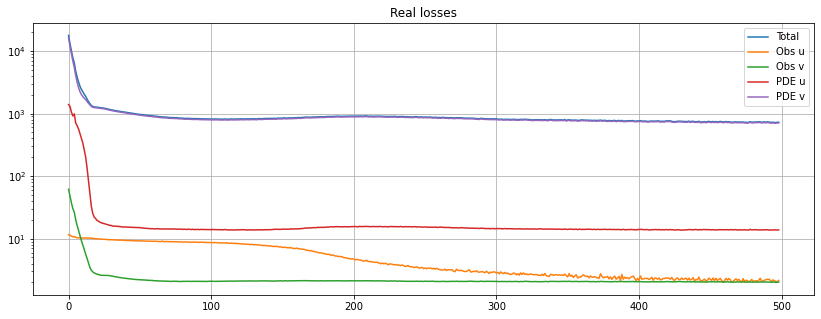

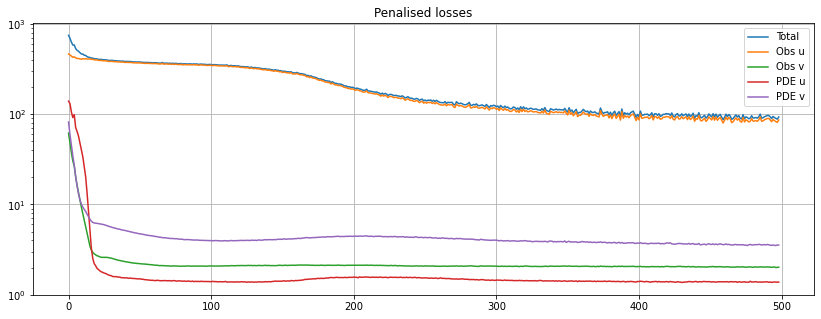

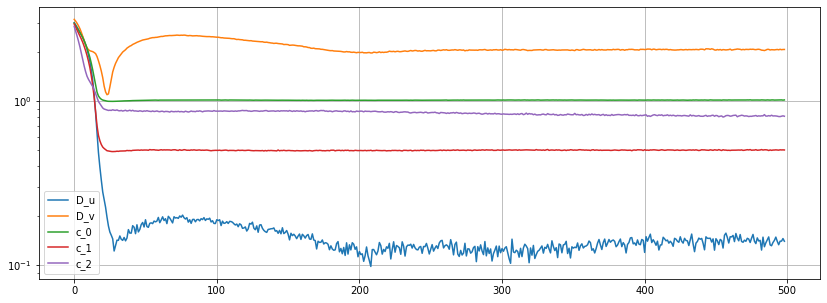

In [40]:
plot_losses(arr_loss_obs_u_2, arr_loss_obs_v_2, arr_loss_pde_u_2, arr_loss_pde_v_2,                
                arr_D_u_2, arr_D_v_2, arr_c_0_2, arr_c_1_2, arr_c_2_2,
                lambda_1 = 40.0, lambda_2 = 1.0, lambda_3 = 0.1, lambda_4 = 0.005,
                start=0, end=-1)

In [41]:
find_grads_2()

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=48.959503641167395>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=18.787425305471803>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1007.327144387927>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1151598.0529371402>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=78335.205825868>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=18.787425305471803>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=10.073271443879266>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=28.789951323428483>)

In [46]:
pinn_2 = pinn.copy()
optimizer_2 = copy.deepcopy(optimizer)

In [47]:
(arr_loss_obs_u2_1, arr_loss_obs_v2_1, arr_loss_pde_u2_1, arr_loss_pde_v2_1,
            arr_D_u2_1, arr_D_v2_1, arr_c_02_1, arr_c_12_1, arr_c_22_1,
D_u, D_v, c_0, c_1, c_2, 
 find_grads2) = create_train(pinn_2, optimizer_2, keras.metrics.MeanSquaredError(), 
                             epochs=100, train_params = True,
                           lambda_1 = 40.0, lambda_2 = 1.0, lambda_3 = 0.5, lambda_4 = 0.05,
                             D_u=D_u, D_v=D_v, c_0=c_0, c_1=c_1, c_2=c_2
                           )


Start of epoch 0
Training acc over epoch: 0.0043
obs u: 3.85163, obs v: 4.93710, pde u:16.29567, pde v:484.81262
D_u: 0.01286, D_v: 3.56795, 
c_0: 0.84078, c_1: 0.18019, c_2: 0.52819
Time taken: 21.64s

Start of epoch 1
Training acc over epoch: 0.0037
obs u: 2.29961, obs v: 5.18718, pde u:14.13777, pde v:375.01660
D_u: 0.01908, D_v: 3.45432, 
c_0: 0.83800, c_1: 0.17399, c_2: 0.52038
Time taken: 11.67s

Start of epoch 2
Training acc over epoch: 0.0035
obs u: 2.15363, obs v: 5.03153, pde u:13.52013, pde v:348.73023
D_u: 0.01910, D_v: 3.52466, 
c_0: 0.84113, c_1: 0.17669, c_2: 0.51037
Time taken: 11.63s

Start of epoch 3
Training acc over epoch: 0.0035
obs u: 2.14908, obs v: 4.92123, pde u:13.16565, pde v:339.04122
D_u: 0.02237, D_v: 3.54907, 
c_0: 0.84730, c_1: 0.17807, c_2: 0.49528
Time taken: 11.63s

Start of epoch 4
Training acc over epoch: 0.0033
obs u: 2.02766, obs v: 4.74702, pde u:12.63008, pde v:323.09598
D_u: 0.02233, D_v: 3.62243, 
c_0: 0.85154, c_1: 0.18123, c_2: 0.49978
Time

Training acc over epoch: 0.0030
obs u: 2.29467, obs v: 3.76838, pde u:9.45516, pde v:216.39620
D_u: 0.02715, D_v: 4.09148, 
c_0: 0.88446, c_1: 0.19407, c_2: 0.46073
Time taken: 11.56s

Start of epoch 42
Training acc over epoch: 0.0028
obs u: 2.00184, obs v: 3.73365, pde u:9.38976, pde v:212.52277
D_u: 0.03044, D_v: 4.08213, 
c_0: 0.88590, c_1: 0.19390, c_2: 0.44828
Time taken: 11.65s

Start of epoch 43
Training acc over epoch: 0.0028
obs u: 2.00371, obs v: 3.73513, pde u:9.34295, pde v:210.17181
D_u: 0.02924, D_v: 4.11011, 
c_0: 0.88387, c_1: 0.19424, c_2: 0.44903
Time taken: 11.63s

Start of epoch 44
Training acc over epoch: 0.0029
obs u: 2.14950, obs v: 3.77533, pde u:9.37840, pde v:214.35117
D_u: 0.03103, D_v: 4.07644, 
c_0: 0.88405, c_1: 0.19291, c_2: 0.44804
Time taken: 11.61s

Start of epoch 45
Training acc over epoch: 0.0027
obs u: 1.91408, obs v: 3.68216, pde u:9.25240, pde v:203.15231
D_u: 0.03196, D_v: 4.11933, 
c_0: 0.88761, c_1: 0.19486, c_2: 0.44792
Time taken: 11.52s

Sta

Training acc over epoch: 0.0028
obs u: 2.12444, obs v: 3.53377, pde u:8.47422, pde v:182.69001
D_u: 0.02931, D_v: 4.13135, 
c_0: 0.89092, c_1: 0.19500, c_2: 0.44358
Time taken: 11.74s

Start of epoch 83
Training acc over epoch: 0.0027
obs u: 2.03816, obs v: 3.58375, pde u:8.46590, pde v:179.90425
D_u: 0.03545, D_v: 4.19764, 
c_0: 0.89003, c_1: 0.19409, c_2: 0.42987
Time taken: 11.63s

Start of epoch 84
Training acc over epoch: 0.0027
obs u: 1.98085, obs v: 3.51976, pde u:8.41409, pde v:176.65360
D_u: 0.03238, D_v: 4.17871, 
c_0: 0.89146, c_1: 0.19710, c_2: 0.43221
Time taken: 11.66s

Start of epoch 85
Training acc over epoch: 0.0027
obs u: 2.07328, obs v: 3.54897, pde u:8.40888, pde v:180.46948
D_u: 0.03085, D_v: 4.13948, 
c_0: 0.88964, c_1: 0.19496, c_2: 0.44408
Time taken: 11.71s

Start of epoch 86
Training acc over epoch: 0.0027
obs u: 2.00928, obs v: 3.51432, pde u:8.23814, pde v:172.07895
D_u: 0.03035, D_v: 4.19252, 
c_0: 0.88820, c_1: 0.19572, c_2: 0.43415
Time taken: 11.65s

Sta

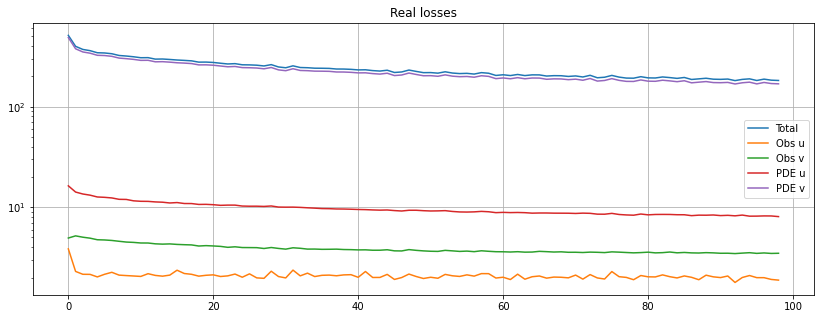

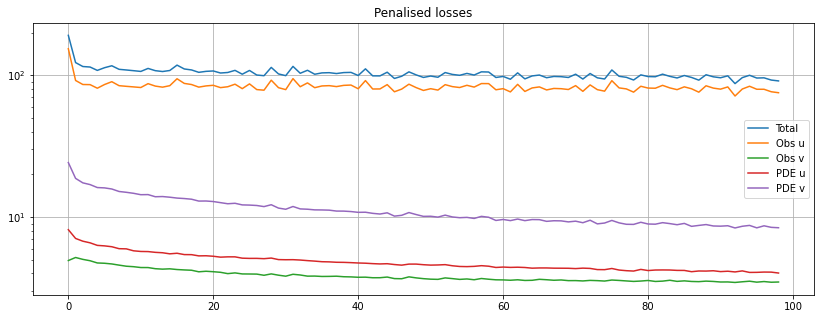

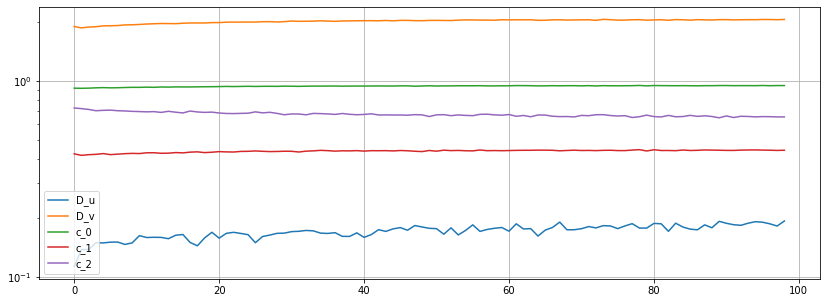

In [48]:
plot_losses(arr_loss_obs_u2_1, arr_loss_obs_v2_1, arr_loss_pde_u2_1, arr_loss_pde_v2_1,
            arr_D_u2_1, arr_D_v2_1, arr_c_02_1, arr_c_12_1, arr_c_22_1,
                lambda_1 = 40.0, lambda_2 = 1.0, lambda_3 = 0.5, lambda_4 = 0.05,
                start=0, end=-1)

In [49]:
find_grads2()

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=49.080053357855974>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=76.15538174858882>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=871.4835932219166>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=324101.30157573783>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=78528.08537256956>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=76.15538174858882>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=217.87089830547916>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=810.2532539393471>)

In [60]:
pinn_3 = pinn.copy()
optimizer_3 = copy.deepcopy(optimizer)

In [61]:
(arr_loss_obs_u3_1, arr_loss_obs_v3_1, arr_loss_pde_u3_1, arr_loss_pde_v3_1,
            arr_D_u3_1, arr_D_v3_1, arr_c_03_1, arr_c_13_1, arr_c_23_1,
D_u, D_v, c_0, c_1, c_2, 
 find_grads3) = create_train(pinn_3, optimizer_3, keras.metrics.MeanSquaredError(), 
                             epochs=100, train_params = True,
                           lambda_1 = 40.0, lambda_2 = 1.0, lambda_3 = 0.5, lambda_4 = 0.5,
                             D_u=float(arr_D_u_2[-1]), D_v=float(arr_D_v_2[-1]), 
                             c_0=float(arr_c_0_2[-1]), c_1=float(arr_c_1_2[-1]), 
                             c_2=float(arr_c_2_2[-1]))


Start of epoch 0
Training acc over epoch: 0.0144
obs u: 3.61647, obs v: 25.80114, pde u:46.94832, pde v:145.61621
D_u: 0.03138, D_v: 1.65664, 
c_0: 0.38932, c_1: 0.00000, c_2: 0.31575
Time taken: 37.64s

Start of epoch 1
Training acc over epoch: 0.0138
obs u: 2.54961, obs v: 25.79385, pde u:37.56032, pde v:89.22405
D_u: 0.04830, D_v: 1.58210, 
c_0: 0.37947, c_1: 0.00000, c_2: 0.30338
Time taken: 20.51s

Start of epoch 2
Training acc over epoch: 0.0124
obs u: 2.20591, obs v: 23.27456, pde u:35.45676, pde v:79.71011
D_u: 0.04610, D_v: 1.56949, 
c_0: 0.37237, c_1: 0.00000, c_2: 0.30574
Time taken: 20.37s

Start of epoch 3
Training acc over epoch: 0.0120
obs u: 2.16622, obs v: 22.44526, pde u:34.17032, pde v:74.56750
D_u: 0.05165, D_v: 1.55767, 
c_0: 0.37336, c_1: 0.00000, c_2: 0.29407
Time taken: 20.39s

Start of epoch 4
Training acc over epoch: 0.0117
obs u: 2.35205, obs v: 21.64039, pde u:32.67872, pde v:70.97275
D_u: 0.05215, D_v: 1.53143, 
c_0: 0.37102, c_1: 0.00000, c_2: 0.29686
Tim

Training acc over epoch: 0.0079
obs u: 2.41078, obs v: 13.67442, pde u:18.52283, pde v:42.01684
D_u: 0.07312, D_v: 1.80581, 
c_0: 0.42987, c_1: 0.00006, c_2: 0.27351
Time taken: 20.30s

Start of epoch 42
Training acc over epoch: 0.0077
obs u: 2.18884, obs v: 13.65944, pde u:18.20190, pde v:40.27544
D_u: 0.07957, D_v: 1.82120, 
c_0: 0.43531, c_1: 0.00000, c_2: 0.26434
Time taken: 20.24s

Start of epoch 43
Training acc over epoch: 0.0077
obs u: 2.22374, obs v: 13.47701, pde u:17.92007, pde v:39.66707
D_u: 0.08173, D_v: 1.85694, 
c_0: 0.44045, c_1: 0.00179, c_2: 0.26825
Time taken: 20.37s

Start of epoch 44
Training acc over epoch: 0.0075
obs u: 2.18638, obs v: 13.20368, pde u:17.47030, pde v:39.32387
D_u: 0.07877, D_v: 1.86637, 
c_0: 0.44215, c_1: 0.00621, c_2: 0.26812
Time taken: 20.25s

Start of epoch 45
Training acc over epoch: 0.0074
obs u: 2.05018, obs v: 13.10984, pde u:17.45742, pde v:39.23436
D_u: 0.08219, D_v: 1.89100, 
c_0: 0.44656, c_1: 0.00387, c_2: 0.26344
Time taken: 20.33s

Training acc over epoch: 0.0059
obs u: 2.02846, obs v: 10.13057, pde u:12.36292, pde v:35.61036
D_u: 0.07129, D_v: 2.22989, 
c_0: 0.54051, c_1: 0.04826, c_2: 0.26969
Time taken: 20.31s

Start of epoch 83
Training acc over epoch: 0.0059
obs u: 2.01933, obs v: 10.13863, pde u:12.51645, pde v:35.84329
D_u: 0.07867, D_v: 2.23839, 
c_0: 0.54331, c_1: 0.04659, c_2: 0.26914
Time taken: 20.57s

Start of epoch 84
Training acc over epoch: 0.0059
obs u: 2.07757, obs v: 10.08791, pde u:12.53767, pde v:36.55170
D_u: 0.07603, D_v: 2.21963, 
c_0: 0.53793, c_1: 0.04517, c_2: 0.26873
Time taken: 20.14s

Start of epoch 85
Training acc over epoch: 0.0058
obs u: 1.86490, obs v: 9.93947, pde u:11.93053, pde v:34.34466
D_u: 0.07198, D_v: 2.24936, 
c_0: 0.55000, c_1: 0.05320, c_2: 0.26950
Time taken: 20.50s

Start of epoch 86
Training acc over epoch: 0.0061
obs u: 2.33206, obs v: 10.07040, pde u:12.30774, pde v:36.73983
D_u: 0.07184, D_v: 2.23538, 
c_0: 0.54170, c_1: 0.04649, c_2: 0.26719
Time taken: 20.45s


In [20]:
(arr_loss_obs_u_3, arr_loss_obs_v_3, arr_loss_pde_u_3, arr_loss_pde_v_3,
 arr_D_u_3, arr_D_v_3, arr_c_0_3, arr_c_1_3, arr_c_2_3,
 D_u, D_v, c_0, c_1, c_2, 
 find_grads_3) = create_train(pinn, optimizer, train_acc_metric, epochs=50, train_params = True,
                              lambda_1 = 40.0, lambda_2 = 1.0, lambda_3 = 0.1, lambda_4 = 0.1,
                              D_u=D_u, D_v=D_v, c_0=c_0, c_1=c_1, c_2=c_2)


Start of epoch 0
Training acc over epoch: 0.0093
obs u: 9.68397, obs v: 9.27934, pde u:38.71111, pde v:260.03641
D_u: 0.00000, D_v: 4.49864, 
c_0: 0.61111, c_1: 0.07522, c_2: 0.55409
Time taken: 15.20s

Start of epoch 1
Training acc over epoch: 0.0098
obs u: 9.60828, obs v: 10.36361, pde u:40.17674, pde v:199.13477
D_u: 0.00000, D_v: 3.84777, 
c_0: 0.57868, c_1: 0.05594, c_2: 0.52751
Time taken: 11.69s

Start of epoch 2
Training acc over epoch: 0.0101
obs u: 9.59725, obs v: 10.99146, pde u:39.80352, pde v:175.83412
D_u: 0.00000, D_v: 3.50102, 
c_0: 0.55882, c_1: 0.04964, c_2: 0.50964
Time taken: 11.67s

Start of epoch 3
Training acc over epoch: 0.0102
obs u: 9.61719, obs v: 11.34746, pde u:38.95402, pde v:163.65825
D_u: 0.00000, D_v: 3.30037, 
c_0: 0.54904, c_1: 0.04508, c_2: 0.50393
Time taken: 11.70s

Start of epoch 4
Training acc over epoch: 0.0103
obs u: 9.56537, obs v: 11.49774, pde u:37.99997, pde v:155.45219
D_u: 0.00000, D_v: 3.23850, 
c_0: 0.55038, c_1: 0.04378, c_2: 0.50213


Training acc over epoch: 0.0082
obs u: 9.09481, obs v: 7.68897, pde u:25.92949, pde v:116.63208
D_u: 0.00915, D_v: 5.07987, 
c_0: 0.68579, c_1: 0.10964, c_2: 0.49468
Time taken: 11.78s

Start of epoch 42
Training acc over epoch: 0.0082
obs u: 9.12771, obs v: 7.63241, pde u:25.97504, pde v:116.21942
D_u: 0.01221, D_v: 5.13575, 
c_0: 0.69388, c_1: 0.10708, c_2: 0.49436
Time taken: 11.61s

Start of epoch 43
Training acc over epoch: 0.0081
obs u: 9.07368, obs v: 7.54283, pde u:25.77032, pde v:115.55135
D_u: 0.00978, D_v: 5.18456, 
c_0: 0.70075, c_1: 0.11363, c_2: 0.49308
Time taken: 11.88s

Start of epoch 44
Training acc over epoch: 0.0081
obs u: 9.11828, obs v: 7.44729, pde u:25.45462, pde v:114.77512
D_u: 0.01557, D_v: 5.22185, 
c_0: 0.70271, c_1: 0.11227, c_2: 0.49580
Time taken: 11.77s

Start of epoch 45
Training acc over epoch: 0.0081
obs u: 9.10600, obs v: 7.41473, pde u:25.27034, pde v:115.31981
D_u: 0.01320, D_v: 5.23614, 
c_0: 0.70053, c_1: 0.11876, c_2: 0.49074
Time taken: 12.00s

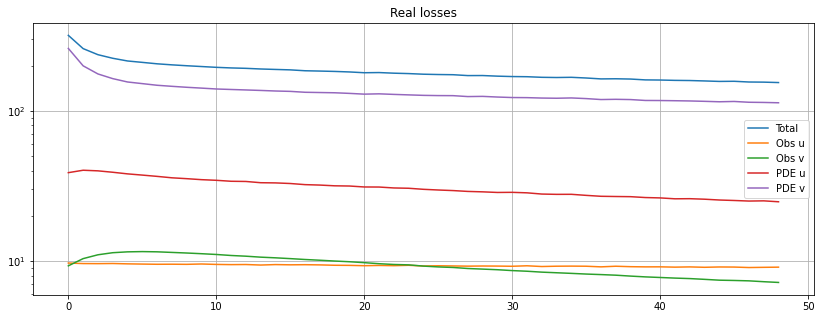

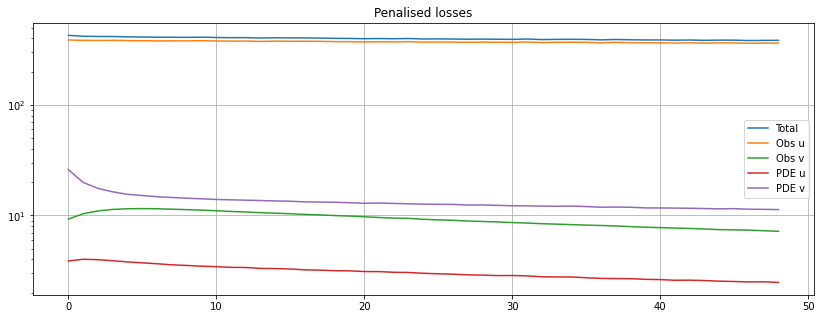

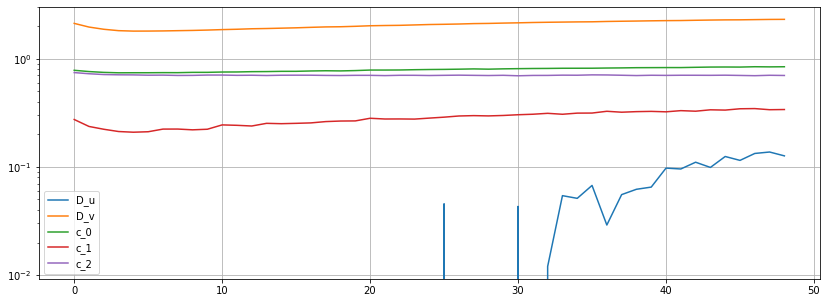

In [21]:
plot_losses(arr_loss_obs_u_3, arr_loss_obs_v_3, arr_loss_pde_u_3, arr_loss_pde_v_3,
            arr_D_u_3, arr_D_v_3, arr_c_0_3, arr_c_1_3, arr_c_2_3,
                lambda_1 = 40.0, lambda_2 = 1.0, lambda_3 = 0.1, lambda_4 = 0.1,
                start=0, end=-1)

In [22]:
find_grads_3()

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=29.842602626088233>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=126.20682367038735>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=3394.407877820598>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=21230.39046513933>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=47748.16420174115>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=126.20682367038735>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=33.94407877820594>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=212.30390465139348>)

In [23]:
(arr_loss_obs_u_4, arr_loss_obs_v_4, arr_loss_pde_u_4, arr_loss_pde_v_4,
 arr_D_u_4, arr_D_v_4, arr_c_0_4, arr_c_1_4, arr_c_2_4,
 D_u, D_v, c_0, c_1, c_2, 
 find_grads_4) = create_train(pinn, optimizer, train_acc_metric, epochs=50, train_params = True,
                              lambda_1 = 40.0, lambda_2 = 2.0, lambda_3 = 0.1, lambda_4 = 0.1,
                              D_u=D_u, D_v=D_v, c_0=c_0, c_1=c_1, c_2=c_2)


Start of epoch 0
Training acc over epoch: 0.0071
obs u: 8.98546, obs v: 5.53635, pde u:22.04813, pde v:131.59087
D_u: 0.03325, D_v: 6.17624, 
c_0: 0.80513, c_1: 0.15610, c_2: 0.53394
Time taken: 15.22s

Start of epoch 1
Training acc over epoch: 0.0068
obs u: 9.00254, obs v: 4.91841, pde u:21.12759, pde v:136.95527
D_u: 0.03667, D_v: 6.55777, 
c_0: 0.82978, c_1: 0.17037, c_2: 0.53237
Time taken: 11.80s

Start of epoch 2
Training acc over epoch: 0.0066
obs u: 8.96663, obs v: 4.60821, pde u:20.76673, pde v:138.11311
D_u: 0.04123, D_v: 6.78757, 
c_0: 0.84061, c_1: 0.17416, c_2: 0.53774
Time taken: 11.83s

Start of epoch 3
Training acc over epoch: 0.0066
obs u: 9.02994, obs v: 4.43081, pde u:20.68693, pde v:138.83278
D_u: 0.04368, D_v: 6.95475, 
c_0: 0.85131, c_1: 0.18285, c_2: 0.53553
Time taken: 11.70s

Start of epoch 4
Training acc over epoch: 0.0065
obs u: 9.03611, obs v: 4.29260, pde u:20.71225, pde v:138.10612
D_u: 0.03589, D_v: 7.06663, 
c_0: 0.85718, c_1: 0.18277, c_2: 0.54554
Time

Training acc over epoch: 0.0057
obs u: 8.71935, obs v: 2.95347, pde u:18.68856, pde v:111.31762
D_u: 0.05922, D_v: 8.35031, 
c_0: 0.94961, c_1: 0.22369, c_2: 0.52833
Time taken: 11.59s

Start of epoch 42
Training acc over epoch: 0.0057
obs u: 8.67633, obs v: 2.92937, pde u:18.67232, pde v:109.95885
D_u: 0.06040, D_v: 8.34021, 
c_0: 0.95396, c_1: 0.21552, c_2: 0.53065
Time taken: 11.54s

Start of epoch 43
Training acc over epoch: 0.0057
obs u: 8.65138, obs v: 2.93283, pde u:18.69030, pde v:109.71298
D_u: 0.05639, D_v: 8.35679, 
c_0: 0.95094, c_1: 0.22207, c_2: 0.52419
Time taken: 11.50s

Start of epoch 44
Training acc over epoch: 0.0057
obs u: 8.69328, obs v: 2.91368, pde u:18.79549, pde v:109.74212
D_u: 0.05623, D_v: 8.34528, 
c_0: 0.94702, c_1: 0.22246, c_2: 0.52802
Time taken: 11.46s

Start of epoch 45
Training acc over epoch: 0.0057
obs u: 8.70676, obs v: 2.91078, pde u:18.74663, pde v:110.37892
D_u: 0.05819, D_v: 8.32736, 
c_0: 0.94901, c_1: 0.22303, c_2: 0.52999
Time taken: 11.65s

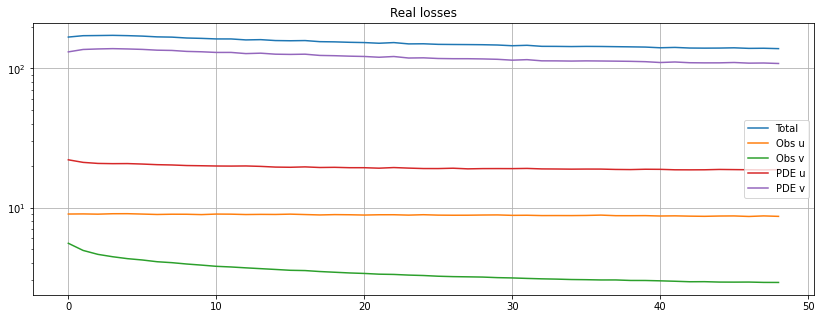

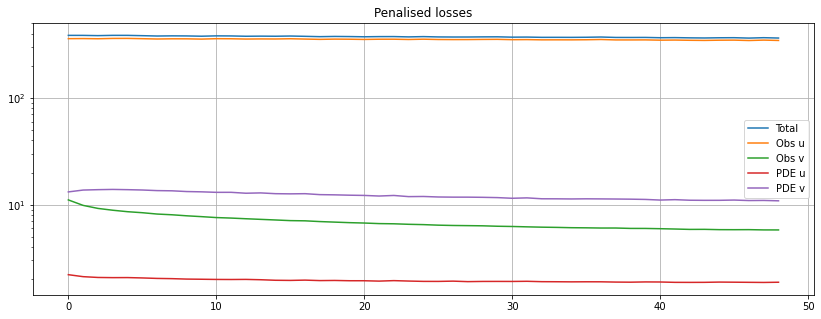

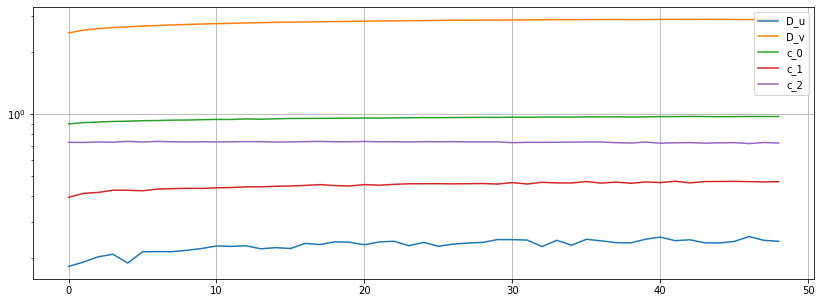

In [25]:
plot_losses(arr_loss_obs_u_4, arr_loss_obs_v_4, arr_loss_pde_u_4, arr_loss_pde_v_4,
            arr_D_u_4, arr_D_v_4, arr_c_0_4, arr_c_1_4, arr_c_2_4,
                lambda_1 = 40.0, lambda_2 = 2.0, lambda_3 = 0.1, lambda_4 = 0.1,
                start=0, end=-1)

In [24]:
find_grads_4()

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=38.62174923459946>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=34.6299626186005>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1796.7417005870664>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=29485.814718576086>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=61794.79877535914>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=138.519850474402>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=17.967417005870622>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=294.85814718576023>)

In [28]:
(arr_loss_obs_u_5, arr_loss_obs_v_5, arr_loss_pde_u_5, arr_loss_pde_v_5,
 arr_D_u_5, arr_D_v_5, arr_c_0_5, arr_c_1_5, arr_c_2_5,
 D_u, D_v, c_0, c_1, c_2, 
 find_grads_5) = create_train(pinn, optimizer, train_acc_metric, epochs=50, train_params = True,
                              lambda_1 = 20.0, lambda_2 = 2.0, lambda_3 =.1, lambda_4 = 0.1,
                              D_u = 0.06299, D_v = 8.34499,c_0=0.95146, c_1= 0.21798, c_2= 0.52561)


Start of epoch 0
Training acc over epoch: 0.0065
obs u: 9.61918, obs v: 2.46089, pde u:8.32557, pde v:49.77559
D_u: 0.10641, D_v: 8.62457, 
c_0: 0.98608, c_1: 0.23507, c_2: 0.41515
Time taken: 15.57s

Start of epoch 1
Training acc over epoch: 0.0056
obs u: 9.22004, obs v: 2.26272, pde u:9.02171, pde v:49.21439
D_u: 0.11530, D_v: 8.85384, 
c_0: 0.99608, c_1: 0.24471, c_2: 0.41947
Time taken: 11.58s

Start of epoch 2
Training acc over epoch: 0.0055
obs u: 8.99623, obs v: 2.19673, pde u:9.72616, pde v:51.63444
D_u: 0.11024, D_v: 8.96727, 
c_0: 0.99979, c_1: 0.24457, c_2: 0.42313
Time taken: 11.54s

Start of epoch 3
Training acc over epoch: 0.0054
obs u: 8.92592, obs v: 2.15207, pde u:10.05931, pde v:51.61841
D_u: 0.10856, D_v: 9.05244, 
c_0: 1.00099, c_1: 0.24379, c_2: 0.42861
Time taken: 11.50s

Start of epoch 4
Training acc over epoch: 0.0053
obs u: 8.80388, obs v: 2.12537, pde u:10.38072, pde v:52.44844
D_u: 0.11192, D_v: 9.11528, 
c_0: 1.00315, c_1: 0.24409, c_2: 0.43420
Time taken: 

Training acc over epoch: 0.0051
obs u: 8.44046, obs v: 1.94654, pde u:13.11039, pde v:57.94327
D_u: 0.10331, D_v: 9.15329, 
c_0: 1.02789, c_1: 0.25412, c_2: 0.45152
Time taken: 11.50s

Start of epoch 42
Training acc over epoch: 0.0050
obs u: 8.32775, obs v: 1.94268, pde u:13.16448, pde v:57.87096
D_u: 0.09919, D_v: 9.16448, 
c_0: 1.02396, c_1: 0.25336, c_2: 0.45455
Time taken: 11.66s

Start of epoch 43
Training acc over epoch: 0.0050
obs u: 8.34650, obs v: 1.94040, pde u:13.22122, pde v:58.08380
D_u: 0.09898, D_v: 9.14419, 
c_0: 1.03096, c_1: 0.25258, c_2: 0.44682
Time taken: 11.56s

Start of epoch 44
Training acc over epoch: 0.0050
obs u: 8.31542, obs v: 1.92868, pde u:13.10905, pde v:56.70050
D_u: 0.09955, D_v: 9.16005, 
c_0: 1.02698, c_1: 0.25018, c_2: 0.44925
Time taken: 11.68s

Start of epoch 45
Training acc over epoch: 0.0050
obs u: 8.30647, obs v: 1.92507, pde u:13.19477, pde v:57.09828
D_u: 0.10132, D_v: 9.14096, 
c_0: 1.02829, c_1: 0.25476, c_2: 0.44587
Time taken: 11.50s

Sta

In [29]:
find_grads_5()

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=28.01932793144137>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=9.951287610377157>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=853.0042534975262>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=7709.997896431393>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=11207.731172576554>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=39.80515044150863>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=8.530042534975271>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=77.09997896431385>)

In [31]:
(arr_loss_obs_u_6, arr_loss_obs_v_6, arr_loss_pde_u_6, arr_loss_pde_v_6,
 arr_D_u_6, arr_D_v_6, arr_c_0_6, arr_c_1_6, arr_c_2_6,
 D_u, D_v, c_0, c_1, c_2, 
 find_grads_6) = create_train(pinn, optimizer, train_acc_metric, epochs=50, train_params = False,
                              lambda_1 = 80.0, lambda_2 = 2.0, lambda_3 = 0.1, lambda_4 = 0.01,
                              D_u=D_u, D_v=D_v, c_0=c_0, c_1=c_1, c_2=c_2)


Start of epoch 0
Training acc over epoch: 0.0050
obs u: 8.21017, obs v: 1.87873, pde u:14.54188, pde v:166.93934
D_u: 0.09495, D_v: 9.08885, 
c_0: 1.02710, c_1: 0.25306, c_2: 0.44845
Time taken: 14.87s

Start of epoch 1
Training acc over epoch: 0.0049
obs u: 8.19434, obs v: 1.87195, pde u:14.58748, pde v:193.70921
D_u: 0.09495, D_v: 9.08885, 
c_0: 1.02710, c_1: 0.25306, c_2: 0.44845
Time taken: 11.53s

Start of epoch 2
Training acc over epoch: 0.0049
obs u: 8.20100, obs v: 1.87678, pde u:14.79306, pde v:214.12299
D_u: 0.09495, D_v: 9.08885, 
c_0: 1.02710, c_1: 0.25306, c_2: 0.44845
Time taken: 11.53s

Start of epoch 3
Training acc over epoch: 0.0049
obs u: 8.15966, obs v: 1.87974, pde u:14.84473, pde v:226.49054
D_u: 0.09495, D_v: 9.08885, 
c_0: 1.02710, c_1: 0.25306, c_2: 0.44845
Time taken: 11.50s

Start of epoch 4
Training acc over epoch: 0.0049
obs u: 8.22877, obs v: 1.88521, pde u:14.80848, pde v:246.71771
D_u: 0.09495, D_v: 9.08885, 
c_0: 1.02710, c_1: 0.25306, c_2: 0.44845
Time

Training acc over epoch: 0.0047
obs u: 7.74480, obs v: 1.92059, pde u:17.80357, pde v:512.16603
D_u: 0.09495, D_v: 9.08885, 
c_0: 1.02710, c_1: 0.25306, c_2: 0.44845
Time taken: 11.42s

Start of epoch 42
Training acc over epoch: 0.0047
obs u: 7.75585, obs v: 1.91539, pde u:17.78770, pde v:518.68025
D_u: 0.09495, D_v: 9.08885, 
c_0: 1.02710, c_1: 0.25306, c_2: 0.44845
Time taken: 11.49s

Start of epoch 43
Training acc over epoch: 0.0047
obs u: 7.66337, obs v: 1.91848, pde u:17.82327, pde v:515.84905
D_u: 0.09495, D_v: 9.08885, 
c_0: 1.02710, c_1: 0.25306, c_2: 0.44845
Time taken: 11.50s

Start of epoch 44
Training acc over epoch: 0.0047
obs u: 7.65126, obs v: 1.91744, pde u:17.80984, pde v:522.33298
D_u: 0.09495, D_v: 9.08885, 
c_0: 1.02710, c_1: 0.25306, c_2: 0.44845
Time taken: 11.42s

Start of epoch 45
Training acc over epoch: 0.0047
obs u: 7.65482, obs v: 1.92375, pde u:17.96101, pde v:529.70098
D_u: 0.09495, D_v: 9.08885, 
c_0: 1.02710, c_1: 0.25306, c_2: 0.44845
Time taken: 11.38s

In [32]:
find_grads_6()

(<tf.Variable 'Variable:0' shape=() dtype=float64, numpy=21.246297285440377>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=12.315355583533016>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=1497.1604066492434>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=334088.04987279826>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=135976.3026268187>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=49.261422334132064>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=14.971604066492487>,
 <tf.Variable 'Variable:0' shape=() dtype=float64, numpy=33.408804987279865>)

In [33]:
(arr_loss_obs_u_7, arr_loss_obs_v_7, arr_loss_pde_u_7, arr_loss_pde_v_7,
 arr_D_u_7, arr_D_v_7, arr_c_0_7, arr_c_1_7, arr_c_2_7,
 D_u, D_v, c_0, c_1, c_2, 
 find_grads_7) = create_train(pinn, optimizer, train_acc_metric, epochs=50, train_params = True,
                              lambda_1 = 80.0, lambda_2 = 2.0, lambda_3 = 0.1, lambda_4 = 0.1,
                              D_u=D_u, D_v=D_v, c_0=c_0, c_1=c_1, c_2=c_2)


Start of epoch 0
Training acc over epoch: 0.0055
obs u: 7.56794, obs v: 3.63681, pde u:23.86179, pde v:322.71557
D_u: 0.05408, D_v: 7.61476, 
c_0: 0.88784, c_1: 0.18784, c_2: 0.47745
Time taken: 15.14s

Start of epoch 1
Training acc over epoch: 0.0056
obs u: 7.57175, obs v: 3.92788, pde u:25.27296, pde v:257.71866
D_u: 0.05327, D_v: 6.86946, 
c_0: 0.84938, c_1: 0.16868, c_2: 0.46532
Time taken: 11.62s

Start of epoch 2
Training acc over epoch: 0.0057
obs u: 7.48381, obs v: 4.21964, pde u:26.59700, pde v:230.63092
D_u: 0.05332, D_v: 6.30096, 
c_0: 0.81837, c_1: 0.15390, c_2: 0.46971
Time taken: 11.64s

Start of epoch 3
Training acc over epoch: 0.0059
obs u: 7.56771, obs v: 4.48582, pde u:27.95993, pde v:213.53245
D_u: 0.05581, D_v: 5.89777, 
c_0: 0.80688, c_1: 0.14673, c_2: 0.46647
Time taken: 11.63s

Start of epoch 4
Training acc over epoch: 0.0060
obs u: 7.59297, obs v: 4.66930, pde u:28.70158, pde v:204.32240
D_u: 0.04530, D_v: 5.65196, 
c_0: 0.78995, c_1: 0.13900, c_2: 0.46446
Time

KeyboardInterrupt: 